In [2]:
!pip install gymnasium pygame torch numpy matplotlib

In [3]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [39]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.actor_fc = nn.Linear(128, action_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.critic_fc = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        policy_probs = self.softmax(self.actor_fc(x))
        state_value = self.critic_fc(x)
        return policy_probs, state_value


In [41]:
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, action_dim, lr=0.0003)

In [6]:
!pip install swig

  Using cached swig-4.3.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (3.5 kB)
Using cached swig-4.3.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.9 MB)


In [7]:
!pip install "gymnasium[box2d]"

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379436 sha256=ca858b21da98745dbb7581284d139c9c952efebf36a1de500faf7954b768583f
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [40]:
class PPO:
    def __init__(self, state_dim, action_dim, lr=0.0003, gamma=0.99, epsilon=0.2, epochs=10):
        self.policy = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epochs = epochs

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs, value = self.policy(state)
        distribution = torch.distributions.Categorical(probs)
        action = distribution.sample()
        return action.item(), distribution.log_prob(action), value

    def compute_advantage(self, rewards, values):
        returns = []
        G = 0
        for reward in reversed(rewards):
            G = reward + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)
        values = torch.tensor(values, dtype=torch.float32)
        return (returns - values).detach()  # Ensure advantage is detached from computation graph

    def update_policy(self, log_probs, values, rewards, old_log_probs):
        advantage = self.compute_advantage(rewards, values)

        log_probs = torch.stack(log_probs)  # Convert list to tensor
        old_log_probs = torch.stack(old_log_probs).detach()  # Detach old log probs
        values = torch.stack(values)

        for _ in range(self.epochs):
            ratio = torch.exp(log_probs - old_log_probs)  # No in-place operations
            clipped_ratio = torch.clamp(ratio.clone(), 1 - self.epsilon, 1 + self.epsilon)  # Clone to avoid in-place modification

            policy_loss = -torch.min(ratio * advantage, clipped_ratio * advantage).mean()
            value_loss = (advantage ** 2).mean()

            loss = policy_loss + 0.5 * value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

In [42]:
num_episodes = 500
reward_history = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    log_probs = []
    values = []
    rewards = []
    old_log_probs = []
    done = False

    while not done:
        action, log_prob, value = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)
        old_log_probs.append(log_prob.detach())

        state = next_state
        total_reward += reward
        done = terminated or truncated

    agent.update_policy(log_probs, values, rewards, old_log_probs)
    reward_history.append(total_reward)

    if episode % 50 == 0:
        print(f"Episode {episode}: Total Reward = {total_reward}")



RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

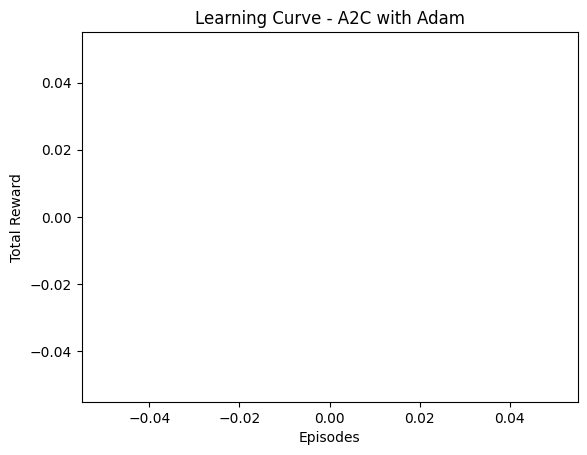

In [43]:
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Learning Curve - PPO with Adam")
plt.show()

In [13]:
class A2C:
    def __init__(self, state_dim, action_dim, lr=0.01, gamma=0.99):
        self.policy = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.SGD(self.policy.parameters(), lr=lr)  # SGD Optimizer
        self.gamma = gamma

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs, value = self.policy(state)
        distribution = torch.distributions.Categorical(probs)
        action = distribution.sample()
        return action.item(), distribution.log_prob(action), value

    def compute_advantage(self, rewards, values):
        returns = []
        G = 0
        for reward in reversed(rewards):
            G = reward + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)
        values = torch.tensor(values, dtype=torch.float32)
        return returns - values  # Advantage = Reward-to-go - Value estimate

    def update_policy(self, log_probs, values, rewards):
        advantage = self.compute_advantage(rewards, values)

        policy_loss = []
        value_loss = []
        for log_prob, value, adv in zip(log_probs, values, advantage):
            policy_loss.append(-log_prob * adv)
            value_loss.append((adv ** 2))  # Mean Squared Error loss

        self.optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum() + torch.stack(value_loss).sum()
        loss.backward()
        self.optimizer.step()

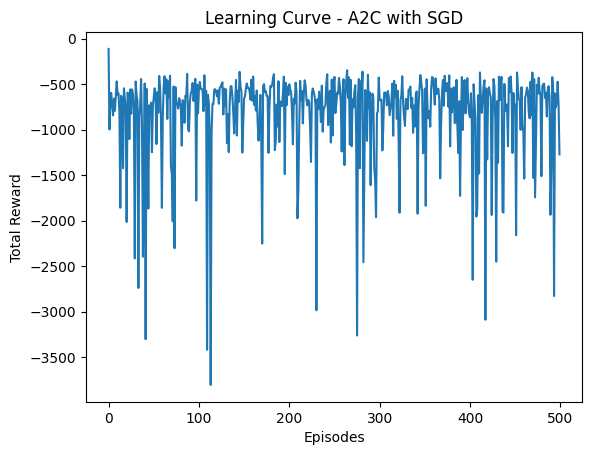

In [16]:
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Learning Curve - A2C with SGD")
plt.show()

In [17]:
class A2C:
    def __init__(self, state_dim, action_dim, lr=0.01, gamma=0.99):
        self.policy = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.RMSprop(self.policy.parameters(), lr=lr)  #rmsprop Optimizer
        self.gamma = gamma

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        probs, value = self.policy(state)
        distribution = torch.distributions.Categorical(probs)
        action = distribution.sample()
        return action.item(), distribution.log_prob(action), value

    def compute_advantage(self, rewards, values):
        returns = []
        G = 0
        for reward in reversed(rewards):
            G = reward + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)
        values = torch.tensor(values, dtype=torch.float32)
        return returns - values  # Advantage = Reward-to-go - Value estimate

    def update_policy(self, log_probs, values, rewards):
        advantage = self.compute_advantage(rewards, values)

        policy_loss = []
        value_loss = []
        for log_prob, value, adv in zip(log_probs, values, advantage):
            policy_loss.append(-log_prob * adv)
            value_loss.append((adv ** 2))  # Mean Squared Error loss

        self.optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum() + torch.stack(value_loss).sum()
        loss.backward()
        self.optimizer.step()

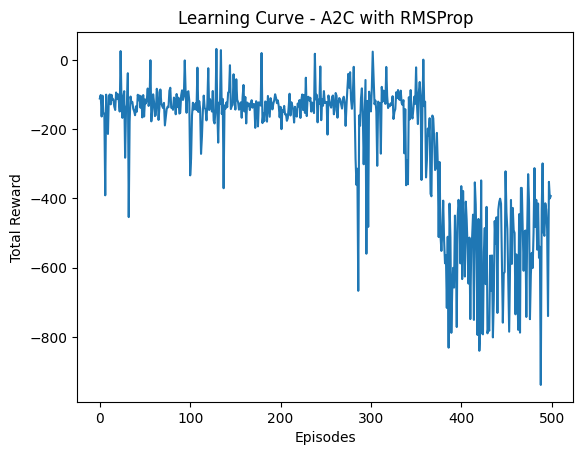

In [20]:
plt.plot(reward_history)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Learning Curve - A2C with RMSProp")
plt.show()